### Zadanie 1.

Poniżej podany jest zestaw danych. Zawiera on brakujące wartości. 
Twoim zadaniem jest przygotować ten zestaw danych do obróbki, a następnie wytrenować klasyfikator przewidujący choroby serca dobierając ilość kroków oraz learning rate za pomocą modelu xgboost.

Wartością docelową jest num

Celem jest:
1. Oczyszczenie zbioru z kolumn pustych
2. Uzupełnienie danych tam, gdzie to konieczne
(W przypadku punktu 1. i 2. zoptymalizują proces oczyszczania,, aby zachować sens, jak i liczebność zbioru)
3. Zaproponuj metodę testowania modeli, aby zredukować problem overfittingu (możliwe jest cross-validation). Przeprowadź proces optymalizacji.
4. Wytrenuj ostateczny model

Zbiór danych: heart.csv

In [148]:
#! pip install optuna
#ani na zajęciach, ani tu, nie instaluje sie optuna.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

import optuna #nie importuje optuny cały czas....
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report

In [2]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [3]:
df.replace('?', float('nan'), inplace=True)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,NaN,NaN,NaN,0
1,29,1,2,120,243,0,0,160,0,0.0,NaN,NaN,NaN,0
2,29,1,2,140,NaN,0,0,170,0,0.0,NaN,NaN,NaN,0
3,30,0,1,170,237,0,1,170,0,0.0,NaN,NaN,6,0
4,31,0,2,100,219,0,1,150,0,0.0,NaN,NaN,NaN,0


In [5]:
df.describe()

,age,sex,cp,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


In [6]:
print(df.isna().sum())

age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalach       1
exang         1
oldpeak       0
slope       190
ca          291
thal        266
num           0
dtype: int64


In [7]:
print(df.isnull().sum())

age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalach       1
exang         1
oldpeak       0
slope       190
ca          291
thal        266
num           0
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    object 
 4   chol      271 non-null    object 
 5   fbs       286 non-null    object 
 6   restecg   293 non-null    object 
 7   thalach   293 non-null    object 
 8   exang     293 non-null    object 
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    object 
 11  ca        3 non-null      object 
 12  thal      28 non-null     object 
 13  num       294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


In [9]:
df.describe(include="all")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,294.000000,294.000000,294.000000,293,271,286,293,293,293,294.000000,104,3,28,294.000000
unique,NaN,NaN,NaN,31,153,2,3,71,2,NaN,3,1,3,NaN
top,NaN,NaN,NaN,120,246,0,0,150,0,NaN,2,0,7,NaN
freq,NaN,NaN,NaN,65,5,266,235,29,204,NaN,91,3,11,NaN
mean,47.826531,0.724490,2.982993,NaN,NaN,NaN,NaN,NaN,NaN,0.586054,NaN,NaN,NaN,0.360544
std,7.811812,0.447533,0.965117,NaN,NaN,NaN,NaN,NaN,NaN,0.908648,NaN,NaN,NaN,0.480977
min,28.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,42.000000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
50%,49.000000,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
75%,54.000000,1.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000


Sprawdzamy ile i gdzie brakuje / checking how much is missing and where

In [10]:
def check_missing(dataframe):
    for column in dataframe.columns:
        missing = column, dataframe[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing(df)

('trestbps', 1)
('chol', 23)
('fbs', 8)
('restecg', 1)
('thalach', 1)
('exang', 1)
('slope', 190)
('ca', 291)
('thal', 266)


##### PL: Braki w 'trestbps' i 'thalach' uzupełnimy średnią policzoną dla tej samej płci (filtracja)

##### EN: We will fill the gaps in 'trestbps' and 'thalach' with the average calculated for the same gender (filtration)

In [11]:
df['trestbps'] = pd.to_numeric(df['trestbps'], errors='coerce')
trestbps_avg = df['trestbps'].mean(skipna=True)
trestbps_avg

132.5836177474403

In [12]:
trestbps_avg_by_sex = df.groupby('sex')['trestbps'].mean()
print(trestbps_avg_by_sex)

sex
0    130.025000
1    133.544601
Name: trestbps, dtype: float64


In [13]:
df['trestbps'] = df['trestbps'].fillna(df.groupby('sex')['trestbps'].transform('mean'))
print(df)

     age  sex  cp  trestbps chol fbs restecg thalach exang  oldpeak slope  \
0     28    1   2     130.0  132   0       2     185     0      0.0   NaN   
1     29    1   2     120.0  243   0       0     160     0      0.0   NaN   
2     29    1   2     140.0  NaN   0       0     170     0      0.0   NaN   
3     30    0   1     170.0  237   0       1     170     0      0.0   NaN   
4     31    0   2     100.0  219   0       1     150     0      0.0   NaN   
..   ...  ...  ..       ...  ...  ..     ...     ...   ...      ...   ...   
289   52    1   4     160.0  331   0       0      94     1      2.5   NaN   
290   54    0   3     130.0  294   0       1     100     1      0.0     2   
291   56    1   4     155.0  342   1       0     150     1      3.0     2   
292   58    0   2     180.0  393   0       0     110     1      1.0     2   
293   65    1   4     130.0  275   0       1     115     1      1.0     2   

      ca thal  num  
0    NaN  NaN    0  
1    NaN  NaN    0  
2    NaN  Na

In [14]:
check_missing(df)

('chol', 23)
('fbs', 8)
('restecg', 1)
('thalach', 1)
('exang', 1)
('slope', 190)
('ca', 291)
('thal', 266)


In [15]:
df['thalach'] = pd.to_numeric(df['thalach'], errors='coerce')
thalach_avg = df['thalach'].mean(skipna=True)
thalach_avg

139.1296928327645

In [16]:
thalach_avg_by_sex = df.groupby('sex')['thalach'].mean()
print(thalach_avg_by_sex)

sex
0    143.425000
1    137.516432
Name: thalach, dtype: float64


In [17]:
df['thalach'] = df['thalach'].fillna(df.groupby('sex')['thalach'].transform('mean'))
print(df)

     age  sex  cp  trestbps chol fbs restecg  thalach exang  oldpeak slope  \
0     28    1   2     130.0  132   0       2    185.0     0      0.0   NaN   
1     29    1   2     120.0  243   0       0    160.0     0      0.0   NaN   
2     29    1   2     140.0  NaN   0       0    170.0     0      0.0   NaN   
3     30    0   1     170.0  237   0       1    170.0     0      0.0   NaN   
4     31    0   2     100.0  219   0       1    150.0     0      0.0   NaN   
..   ...  ...  ..       ...  ...  ..     ...      ...   ...      ...   ...   
289   52    1   4     160.0  331   0       0     94.0     1      2.5   NaN   
290   54    0   3     130.0  294   0       1    100.0     1      0.0     2   
291   56    1   4     155.0  342   1       0    150.0     1      3.0     2   
292   58    0   2     180.0  393   0       0    110.0     1      1.0     2   
293   65    1   4     130.0  275   0       1    115.0     1      1.0     2   

      ca thal  num  
0    NaN  NaN    0  
1    NaN  NaN    0  


In [18]:
check_missing(df)

('chol', 23)
('fbs', 8)
('restecg', 1)
('exang', 1)
('slope', 190)
('ca', 291)
('thal', 266)


##### PL: Dla 'chol' braki uzupełnimy średnią wgl wieku

##### EN: For 'chol' we will fill in the gaps with the average according to the age

In [19]:
df['chol'] = pd.to_numeric(df['chol'], errors='coerce')
chol_avg = df['chol'].mean(skipna=True)
chol_avg

250.84870848708488

In [20]:
chol_avg_by_age = df.groupby('age')['chol'].mean()
print(chol_avg_by_age)
# na dole wiek 66 - ma NaN - jedyne znaczenie

age
28    132.000000
29    243.000000
30    237.000000
31    244.500000
32    301.500000
33    272.000000
34    187.750000
35    231.200000
36    228.400000
37    233.250000
38    243.166667
39    241.444444
40    319.666667
41    256.181818
42    229.428571
43    231.636364
44    299.714286
45    237.666667
46    234.923077
47    245.333333
48    251.882353
49    233.750000
50    235.333333
51    206.444444
52    253.000000
53    291.545455
54    261.000000
55    275.733333
56    246.222222
57    287.000000
58    236.222222
59    268.000000
60    247.000000
61    293.000000
62    232.000000
63    223.000000
65    281.333333
66           NaN
Name: chol, dtype: float64


In [21]:
df['chol'] = df['chol'].fillna(df.groupby('age')['chol'].transform('mean'))
print(df)

     age  sex  cp  trestbps   chol fbs restecg  thalach exang  oldpeak slope  \
0     28    1   2     130.0  132.0   0       2    185.0     0      0.0   NaN   
1     29    1   2     120.0  243.0   0       0    160.0     0      0.0   NaN   
2     29    1   2     140.0  243.0   0       0    170.0     0      0.0   NaN   
3     30    0   1     170.0  237.0   0       1    170.0     0      0.0   NaN   
4     31    0   2     100.0  219.0   0       1    150.0     0      0.0   NaN   
..   ...  ...  ..       ...    ...  ..     ...      ...   ...      ...   ...   
289   52    1   4     160.0  331.0   0       0     94.0     1      2.5   NaN   
290   54    0   3     130.0  294.0   0       1    100.0     1      0.0     2   
291   56    1   4     155.0  342.0   1       0    150.0     1      3.0     2   
292   58    0   2     180.0  393.0   0       0    110.0     1      1.0     2   
293   65    1   4     130.0  275.0   0       1    115.0     1      1.0     2   

      ca thal  num  
0    NaN  NaN    0

In [22]:
check_missing(df)

('chol', 1)
('fbs', 8)
('restecg', 1)
('exang', 1)
('slope', 190)
('ca', 291)
('thal', 266)


##### PL:Został nam pojedyńczy brak dla 'chol' (wiek 66 - jedyne i ostatnie znaczenie w bazie). Zastąpimy go średnim dla wieku 65.

##### EN: We are left with a single missing value for 'chol' (age 66 - the only and last value in the database). We will replace it with the average for age 65.

In [23]:
df.loc[(df['age'] == 66) & (df['chol'].isnull()), 'chol'] = df.loc[df['age'] == 65, 'chol'].mean()

In [24]:
check_missing(df)

('fbs', 8)
('restecg', 1)
('exang', 1)
('slope', 190)
('ca', 291)
('thal', 266)


##### PL: Pojednyńcze braki 'restecg' i 'exang' oraz 'fbs' uzipełniamy 0, ponieważ znaczenia tam 0 i 1 i przeważają 0.

##### EN: We fill in the single missing words 'restecg', 'exang' and 'fbs' with 0, because there are the values 0 and 1 and zero-values predominates.

In [25]:
df['restecg'] = df['restecg'].fillna('0')
df['exang'] = df['exang'].fillna('0')
df['fbs'] = df['fbs'].fillna('0')

In [26]:
check_missing(df)

('slope', 190)
('ca', 291)
('thal', 266)


Kasujemy kolumny 'slope', 'ca' i 'thal' - za dużo braków.

In [27]:
df = df.drop(['slope','ca', 'thal'], axis=1)

In [28]:
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
num         0
dtype: int64


In [29]:
check_missing(df)

In [30]:
df.describe()

,age,sex,cp,trestbps,chol,thalach,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,132.574915,251.051500,139.144303,0.586054,0.360544
std,7.811812,0.447533,0.965117,17.597095,65.211681,23.550792,0.908648,0.480977
min,28.000000,0.000000,1.000000,92.000000,85.000000,82.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,120.000000,211.250000,122.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,130.000000,245.000000,140.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,140.000000,280.000000,155.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,200.000000,603.000000,190.000000,5.000000,1.000000


##### PL: Co było możliwe uzypełnilismy, resztę skasowaliśmy. Zapisujemy zmiany do nowego pliku, z którym będziemy modelować.

##### EN: We have completed everything possible and the rest was deleted. We are saving the changes to a new file that we will use for modelling.

In [31]:
#: writing to a file to see what was done and what was not done there
df.to_csv('heart_my_edit_for_modeling.csv', index=False)

In [32]:
df = pd.read_csv("heart_my_edit_for_modeling.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,28,1,2,130.0,132.0,0,2,185.0,0,0.0,0
1,29,1,2,120.0,243.0,0,0,160.0,0,0.0,0
2,29,1,2,140.0,243.0,0,0,170.0,0,0.0,0
3,30,0,1,170.0,237.0,0,1,170.0,0,0.0,0
4,31,0,2,100.0,219.0,0,1,150.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160.0,331.0,0,0,94.0,1,2.5,1
290,54,0,3,130.0,294.0,0,1,100.0,1,0.0,1
291,56,1,4,155.0,342.0,1,0,150.0,1,3.0,1
292,58,0,2,180.0,393.0,0,0,110.0,1,1.0,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  294 non-null    float64
 4   chol      294 non-null    float64
 5   fbs       294 non-null    int64  
 6   restecg   294 non-null    int64  
 7   thalach   294 non-null    float64
 8   exang     294 non-null    int64  
 9   oldpeak   294 non-null    float64
 10  num       294 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 25.4 KB


In [34]:
numerical= df.select_dtypes('number').columns

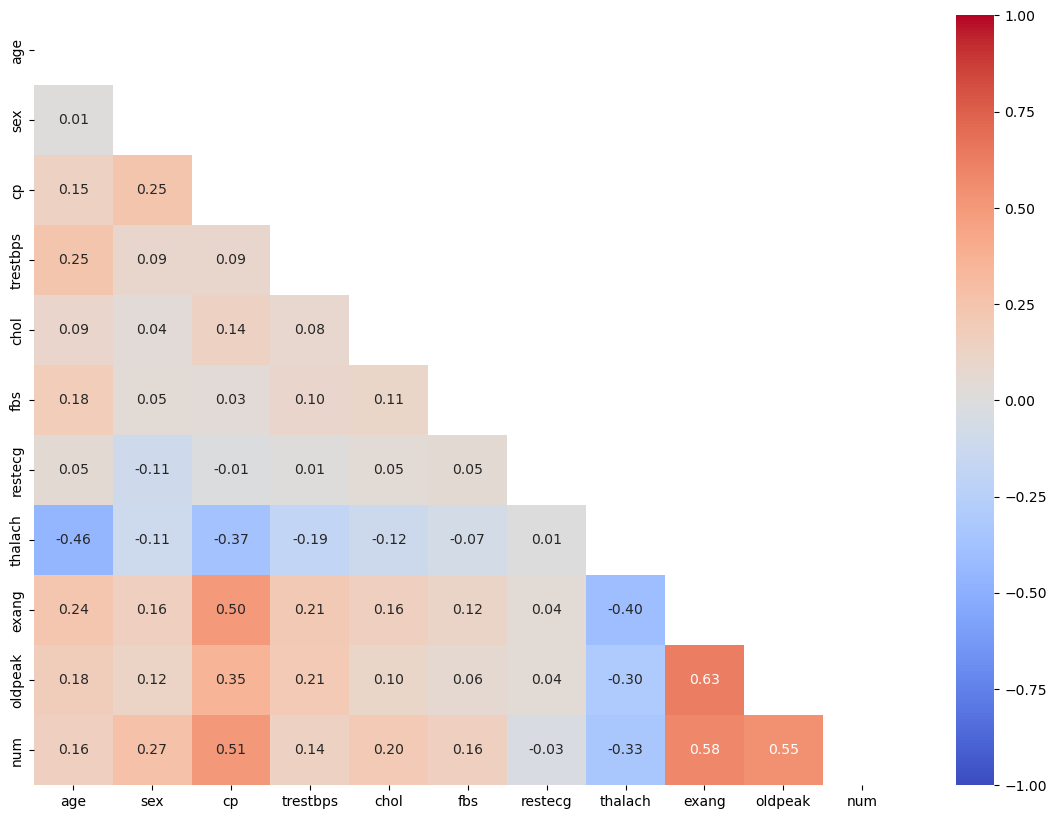

In [35]:
matrix = np.triu(df[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

##### PL: Kilka charakterystyk maja korelacje powyżej 0,5 z wyjściowa kolumna 'num' (Diagnosis of heart disease). To 'CP', 'exang' oraz 'oldpeak'

##### EN: Several characteristics have correlations above 0.5 with the initial 'num' column (Diagnosis of heart disease). These are 'CP', 'exang' and 'oldpeak'

##### PL: Modelowanie. Najpierw podstawowy model - DummyClassifier

##### EN: First model, basic - DummyClassifier

In [36]:
accuracy =[]
model_names =[]

X= df.drop('num', axis=1)
y= df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

model = DummyClassifier(strategy='constant', constant=1)
pipe = make_pipeline(StandardScaler(), model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and  accuracy score is : 0.382


,Accuracy
DummyClassifier,0.382


1. Logistic Regression,
2. Support vector classifier (SVC) and
3. K-Nearest Neighbors (KNN)

In [38]:
accuracy =[]
model_names =[]


X= df.drop('num', axis=1)
y= df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

lr = LogisticRegression(solver='liblinear')
svc = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,svc,knn]

for model in models: 
    pipe = make_pipeline(StandardScaler(), model) #acc: 0,8427, 0,7978, 0,8315
    # pipe = make_pipeline(MinMaxScaler(), model) #acc: 0,8315, 0,7865, 0,7865
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic','SVC','KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8427
model : SVC() and  accuracy score is : 0.7978
model : KNeighborsClassifier() and  accuracy score is : 0.8315


,Accuracy
Logistic,0.8427
SVC,0.7978
KNeighbors,0.8315


For logistic regression we are looking for hyperparameters

In [39]:
X= df.drop('num', axis=1)
y= df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])

param_grid = {'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 'classifier__solver': ['liblinear', 'saga']}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

print("Best parameters: ", grid.best_params_)
print("Best cross-validation score: {:.4f}".format(grid.best_score_))

Best parameters:  {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.8488


The same for KNN

In [40]:
X= df.drop('num', axis=1)
y= df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

pipe = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())])

param_grid = {'classifier__n_neighbors': [1, 3, 5, 7], 'classifier__weights': ['uniform', 'distance'], 'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train)

print("Best parameters: ", grid.best_params_)
print("Best cross-validation score: {:.4f}".format(grid.best_score_))

Best parameters:  {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best cross-validation score: 0.8439


The same for SVC

In [41]:
X= df.drop('num', axis=1)
y= df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SVC())])

param_distributions = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'classifier__degree': [1, 2, 3, 4]}

random_search = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=5)

random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best cross-validation score: {:.4f}".format(random_search.best_score_))

Best parameters:  {'classifier__kernel': 'poly', 'classifier__gamma': 10, 'classifier__degree': 1, 'classifier__C': 0.1}
Best cross-validation score: 0.8341


For SVC, looking for the better parameters helped to increase the accuracy from 0.7978 to 0.8341.

For KNN it increased for 0,0124 : from 0.8315 to 0.8439.

For logistic regression, it was possible to increase accuracy only by 0.0061.

... and XGBoost

In [42]:
accuracy =[]
model_names =[]


X= df.drop('num', axis=1)
y= df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

xgbc = XGBClassifier(random_state=123)

models = [xgbc]

for model in models: 
    # pipe = make_pipeline(StandardScaler(), model) #acc: 0,809
    pipe = make_pipeline(MinMaxScaler(), model) #acc: 0,8202
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBoost']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

,Accuracy
XGBoost,0.8202


In [45]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[49  6]
 [10 24]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        55
           1       0.80      0.71      0.75        34

    accuracy                           0.82        89
   macro avg       0.82      0.80      0.80        89
weighted avg       0.82      0.82      0.82        89



In [46]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(3, 4, 5),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [47]:
xgb = XGBClassifier(random_state=123)
random_search = RandomizedSearchCV(estimator=xgb,
                                   param_distributions=param_distributions,
                                   cv=5,
                                   n_iter=10,
                                   n_jobs=-1,
                                   verbose=2)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:20:33] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "classifier__C", "classifier__degree", "classifier__gamma", "classifier__kernel" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=123, ...),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.001, 0.01, 0.1, 1,
                                                          10, 100],
                                        'classifier__degree': [1, 2, 3, 4],
                                        'classifier__gamma': [0.001, 0.01, 0.1,
                                                              1, 10, 100],
                                        'classifier__kernel': ['linear', 'poly',
                                                               'rbf',
                                                               'sigmoid']},
                   verbose=2)

In [48]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[49  6]
 [13 21]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        55
           1       0.78      0.62      0.69        34

    accuracy                           0.79        89
   macro avg       0.78      0.75      0.76        89
weighted avg       0.79      0.79      0.78        89



In case of XGBoost accuracy decreased from 0.8204 to 0.78

##### The best models for this data set (at this moment) according to accuracy of the model:
1. Logistic regression: 0.8488
2. KNN: 0.8439
3. SVC: 0.8341

##### XGBoost wasn't good for this dataset :)

In [ ]:
# visualization